# Selected features and their coefficients

The best model (among all models evaluated) for each target is determined in 'compare_models'. Since the training data and testing data was kept separated through all steps in the models, each of the eigth different cross validation splits saw a different set of the samples when applying the feature selecetion. Hence, the features selected by one model can differ between the different splits (CV iterations) it is evaluated on. 
- intersection = features selected in all CV splits of a model
- union = features selected at least in one CV split

Here, the selected features in one CV split are ordered by their absolute value from 0 to k, where k is the number of features selected after the filtering steps. The higher absolute value, the more important and the lower the order. 'times top 3' therefore means how many times the given feature were selected and recieved one of the three highest absolute coefficients (order = 0, 1 or 2). 

The learning algorithm Lasso performs further selection by setting some coefficients to 0. Here, 'times selected in fitted model' means how many times the given feature was both selected by the filtering methods and by Lasso (coefficient > 0).

In [1]:
#import libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from IPython.display import display

from functools import partial #to pass parameters to function inside another function
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import svm

In [2]:
#import self-made functions
%run /Users/mariekececilia/Documents/master_thesis_code/methods.ipynb

In [3]:
#set a random seed to make reproducible results (used in mutual information)
seed = 0

In [4]:
#figure saving settings for this notebook
folder_path_figures = 'Figures/'
figure_format = 'pdf'

## Load and clean data

In [5]:
#load transcriptional and fluxomic data
gexp, flux = load_gerosa()

#clean the transcriptional data (remove duplicates)
gexp, duplicates = clean_gexp_g(gexp)

#define features
X = gexp

#get correlations of genes with the targets to add to table over selected features
corr = get_all_correlations(gexp, flux.abs()[['R_AKGDH', 'R_ICDHyr', 'R_PPC']], column_names = ['gene', 'reaction', 'r'] )

## Models to analyse selected features of

Need to build and fit the models again to extract the selected features and their coefficients from each cross-validation split.

In [6]:
ppc_models = dict()
ppc_models['best_model'] = Pipeline( steps = [
    ('filter', CoVSelector(p = 0.1)),
    ('selection', SelectKBest(score_func = f_regression,
                              k = 10)),
    ('standardize', StandardScaler()),
    ('m', linear_model.Lasso(alpha = 0.05))])

akgdh_models = dict()
akgdh_models['best_model'] = Pipeline( steps = [
    ('filter', CoVSelector(p = 0.2)),
    ('selection', SelectKBest(score_func = partial(
        mutual_info_regression, 
        random_state=seed), 
                              k = 20)),
    ('standardize', StandardScaler()),
    ('m', linear_model.Lasso(alpha = 0.1))])


icdhyr_models = dict()
icdhyr_models['best_model'] = Pipeline( steps = [
    ('filter', CoVSelector(p = 0.2)),
    ('selection', SelectKBest(score_func = partial(
        mutual_info_regression, 
        random_state=seed), 
                              k = 30)),
    ('standardize', StandardScaler()),
    ('m', linear_model.Lasso(alpha = 0.001))])

In [7]:
model_dicts = [ppc_models, 
               akgdh_models,
               icdhyr_models
         ]
targets = ['R_PPC',
           'R_AKGDH',
           'R_ICDHyr'
          ]

## Get and count selected features

In [8]:
#dicts to store results in for each target, allows further investigation
selected_features_and_coef_dicts = dict()
selected_df_dicts = dict()
selected_merged_dicts = dict()
stats_dicts = dict()
df_selected_dict = dict()
top_genes_dict = dict()

for model_dict, target in zip(model_dicts, targets):
    #-----------------------------------------------------------------------------------------
    #     Fit models and get selected features and their coefficients
    #-----------------------------------------------------------------------------------------
    #get features and coefficients, stored in nested dict:
    # [model] -> [0] -> [test_set] -> selected features when test_set is excluded (array)
    # [model] -> [1] -> [test_set] -> coefficients of the respective selected features (array)
    selected_features_and_coef = dict()
    for model_name, pipeline in model_dict.items():
        selected_features_and_coef[model_name] =  get_loo_selected_feature_names_and_coef(pipeline, X, flux[target])
    
    #store in a dict of dict 
    selected_features_and_coef_dicts[target] = selected_features_and_coef
    
    #-----------------------------------------------------------------------------------------
    #      Match features with their coefficients, order by coefficient and merge results
    #-----------------------------------------------------------------------------------------
    #turn selected features and coefficients into dataframes, store in nested dicts:
    # target_selected_df[model] -> [test set] -> selected features, their coefficient and order (sorted by absolute value/order)
    # target_selected_df_merged[model] -> merging of all dataframes from the above dict
    selected_df = dict() 
    selected_merged = dict() 
    for model_name, pipeline in model_dict.items():
        selected_dict, coef_dict = selected_features_and_coef[model_name]
        selected_df[model_name] = get_loo_selected_features_and_coef_df(selected_dict, coef_dict)
        selected_merged[model_name] = get_loo_selected_features_and_coef_df_merged(selected_dict, coef_dict)
    
    #store in dict of dict
    selected_df_dicts[target] = selected_df
    selected_merged_dicts[target] = selected_merged
    
    #write results to file
    for model, df in selected_merged.items():
        df.to_csv('Tables/selected_features_coef_%s_%s.csv' % (target[2:], model), index = False)
    
    #-----------------------------------------------------------------------------------------
    #       Analyse occurence of selected features
    #-----------------------------------------------------------------------------------------
    #get intersection and union, stored in nested dict:
    # [model] -> ['intersection'] -> list of features in intersection 
    # [model] -> ['union'] -> list of features in union
    stats = dict() 
    for model_name, selected_features_and_coef in selected_features_and_coef.items():
        stats[model_name] = get_selected_features_intersection_and_union(selected_features_and_coef[0])
    
    #store in dict of dicts
    stats_dicts[target] = stats
    
    #print intersection and union
    print('-----------------------------------')
    print(target[2:])
    print('-----------------------------------')
    print('K: intersection: Union: Model:')
    for model_name in model_dict.keys():
        #print('\t\t\t', model_name)
        ideally = selected_merged[model_name]['order'].nunique()
        intersection = len(stats[model_name]['intersection'])
        union = len(stats[model_name]['union'])
        print('%s\t%s\t%s\t%s' %(ideally, intersection, union, model_name))
        
    #display number of times selected etc.
    print('-----------------------------------')
    print('''Selected features sorted by 
        1) times selected in fitted model (descending)
        2) times top 3 (descending)
        3) times selecet by filters (descending)
        4) times 0 (ascending)
        ''')
    top_genes = set()
    for model_name in model_dict.keys():
        #get times selected by filters
        df = selected_merged[model_name]
        df_selected = df.groupby(['feature']).size().reset_index(name='times selected by filters')
        df_selected = df_selected.set_index('feature')

        #get times zero
        df = selected_merged[model_name]
        df = df[df['coef'] == 0]
        df_zero = df.groupby(['feature']).size().reset_index(name='times deselected by Lasso')
        df_zero = df_zero.set_index('feature')

        #get times top 3
        df = selected_merged[model_name]
        df = df[(df['order'] == 0) | (df['order'] == 1) | (df['order'] == 2)]
        df_top3 = df.groupby(['feature']).size().reset_index(name='times top 3')
        df_top3 = df_top3.set_index('feature')

        #add times zero and replace nan with 0
        df_selected['times deselected by Lasso'] = df_zero['times deselected by Lasso']
        df_selected['times deselected by Lasso'] = df_selected['times deselected by Lasso'].fillna(0)

        #add times selected in fitted model (difference of selected and deselected)
        df_selected['times selected in fitted model'] = (df_selected['times selected by filters']
                                                         - df_selected['times deselected by Lasso'])

        #add times top3 and replace NaN with 0
        df_selected['times top 3'] = df_top3['times top 3']
        df_selected['times top 3'] = df_selected['times top 3'].fillna(0)

        #convert floats (because of NaN) to int
        df_selected = df_selected.astype({"times deselected by Lasso":'int',
                                          "times selected in fitted model" : 'int',
                                          "times top 3":'int'})
        #add correlation with target
        df_selected['r'] = df_selected.index.map(lambda x: 
                                                 corr[(corr['gene'] == x) & 
                                                                (corr['reaction'] == target)]
                                                 .iloc[0,2])

        #sort by selected, top3, 0
        df_selected = df_selected.sort_values(by = ['times selected in fitted model',
                                                    'times top 3', 
                                                    'times selected by filters', 
                                                    'times deselected by Lasso'], 
                                              ascending = [False,
                                                           False,
                                                           False,
                                                           True])
        #print results
        print('- Model: ' + model_name)
        display(df_selected.head(15))
        
        #store df in dict
        df_selected_dict[target + '_' + model_name] = df_selected
        
        #write results to file
        df_selected.to_csv('Tables/selected_features_count_%s_%s.csv' % (target[2:], model), index = True)


        #extract the ones that are selected in fitted models at least half the time (4 iterations)
        top_genes.update(df_selected[
            df_selected['times selected in fitted model']>=4].index.tolist())
    
    top_genes_dict[target] = top_genes
    print('Selected in a fitted model at least 4 out of 8 times:')
    print(top_genes)
    print()

-----------------------------------
PPC
-----------------------------------
K: intersection: Union: Model:
10	2	46	best_model
-----------------------------------
Selected features sorted by 
        1) times selected in fitted model (descending)
        2) times top 3 (descending)
        3) times selecet by filters (descending)
        4) times 0 (ascending)
        
- Model: best_model


,times selected by filters,times deselected by Lasso,times selected in fitted model,times top 3,r
feature,,,,,
b1660,8,1,7,5,0.952381
b0044,7,0,7,4,-0.976190
b4346,8,2,6,6,0.976190
b1286,7,3,4,2,1.000000
b0277,1,0,1,1,-0.619048
b0472,1,0,1,1,0.952381
b0776,1,0,1,1,0.952381
b1807,1,0,1,1,0.857143
b2187,1,0,1,1,0.976190


Selected in a fitted model at least 4 out of 8 times:
{'b4346', 'b1660', 'b1286', 'b0044'}

-----------------------------------
AKGDH
-----------------------------------
K: intersection: Union: Model:
20	1	95	best_model
-----------------------------------
Selected features sorted by 
        1) times selected in fitted model (descending)
        2) times top 3 (descending)
        3) times selecet by filters (descending)
        4) times 0 (ascending)
        
- Model: best_model


,times selected by filters,times deselected by Lasso,times selected in fitted model,times top 3,r
feature,,,,,
b0762,6,1,5,5,0.928571
b2318,6,1,5,4,0.976190
b1535,8,5,3,0,1.000000
b1798,6,4,2,2,0.952381
b0730,2,0,2,2,0.785714
b1912,6,4,2,1,0.952381
b3594,3,1,2,1,-0.952381
b1926,4,2,2,0,-0.928571
b0649,5,4,1,1,0.952381


Selected in a fitted model at least 4 out of 8 times:
{'b2318', 'b0762'}



/Users/mariekececilia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-02, tolerance: 3.681e-03
  model = cd_fast.enet_coordinate_descent(
/Users/mariekececilia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-02, tolerance: 3.717e-03
  model = cd_fast.enet_coordinate_descent(
/Users/mariekececilia/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

-----------------------------------
ICDHyr
-----------------------------------
K: intersection: Union: Model:
30	2	131	best_model
-----------------------------------
Selected features sorted by 
        1) times selected in fitted model (descending)
        2) times top 3 (descending)
        3) times selecet by filters (descending)
        4) times 0 (ascending)
        
- Model: best_model


,times selected by filters,times deselected by Lasso,times selected in fitted model,times top 3,r
feature,,,,,
b0762,7,0,7,4,0.952381
b1798,6,1,5,0,0.976190
b1535,8,4,4,1,0.976190
b0730,3,0,3,3,0.809524
b0067,3,0,3,2,0.952381
b1432,5,2,3,1,0.976190
b0421,3,0,3,1,0.880952
b1912,7,4,3,0,0.976190
b1926,4,1,3,0,-0.952381


Selected in a fitted model at least 4 out of 8 times:
{'b1535', 'b1798', 'b0762'}



## Explore selected features

### CoV

In [9]:
for target in targets:
    print('\nCoV of selected genes for %s:' % target[2:])
    #calculate CoV
    top_genes_list = top_genes_dict[target]
    print(np.round(gexp[top_genes_list].std()/gexp[top_genes_list].mean(),4))


CoV of selected genes for PPC:
b4346    0.3316
b1660    0.2834
b1286    0.3958
b0044    0.2551
dtype: float64

CoV of selected genes for AKGDH:
b2318    0.3656
b0762    0.3729
dtype: float64

CoV of selected genes for ICDHyr:
b1535    0.4249
b1798    0.4475
b0762    0.3729
dtype: float64


### Duplicated genes?

In [10]:
for target in targets:
    print('\nSelected genes for %s:' % target[2:])
    for gene in top_genes_dict[target]: 
        if gene in duplicates: 
            print(gene, '– alternatively:', sorted(duplicates[gene])) 
        else:
            print (gene, '– no duplicates')


Selected genes for PPC:
b4346 – no duplicates
b1660 – no duplicates
b1286 – no duplicates
b0044 – no duplicates

Selected genes for AKGDH:
b2318 – no duplicates
b0762 – no duplicates

Selected genes for ICDHyr:
b1535 – no duplicates
b1798 – no duplicates
b0762 – no duplicates


### Selected features plotted against target


Selected features for predicting PPC:



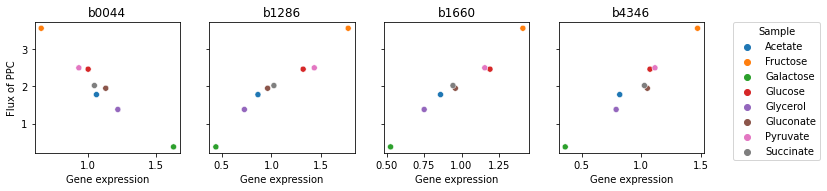


Selected features for predicting AKGDH:



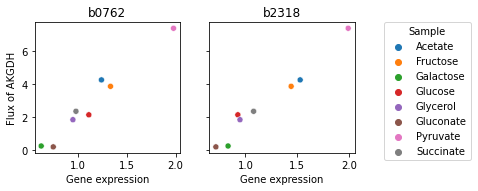


Selected features for predicting ICDHyr:



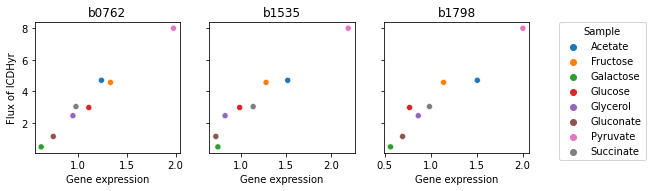

In [11]:
for target in targets:
    #------------------------- Figure settings ------------------------------------------
    #titles and outputs
    suptitle = 'Selected features for predicting %s' % (target[2:])
    figure_name = 'selected_features_vs_%s' % (target[2:])
    print('\n' + suptitle + ':\n')
    
    #what to plot
    data = gexp.copy()
    data = data[top_genes_dict[target]] #extract transcription data of the features
    y_col = target
    data[y_col] = flux[target]  #extract flux data of the target  
    plot_order = sorted(top_genes_dict[target]) 
    
    #hue/legend settings:
    hue = 'Sample'
    data[hue] = data.index    
    palette = 'tab10' 

    #subplot arrangement and figure size (scale)
    nrows = 2
    ncols = 4
    scale = 3   

    #------------------------- Actual plotting -----------------------------------------

    #create figure and fill in subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(
        ncols*scale,nrows*scale), sharex = False, sharey = True)

    #------------------------- Subplots ------------------------------------------------
    for gene, ax in zip(plot_order, fig.axes):

        #plot data
        ax = sns.scatterplot(x=gene, y=y_col, data=data, ax = ax,  hue = hue,
                        palette = palette)
        #keep legend for later
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()

        #set title
        ax.set_ylabel('Flux of %s' % target[2:])
        ax.set_xlabel('Gene expression')
        ax.set_title(gene)

    #------------------------- Common for figure ------------------------------------------

    #remove empty subplots from grid
    nplots = len(plot_order)
    remove_empty_subplots(fig, axes, nplots, nrows, ncols)

    #add legend and title + adjust figure layout
    axes[0][min(ncols-1, nplots-1)].legend(handles, labels, 
               loc = 'upper left',
               bbox_to_anchor= (1.2, 1),
               borderaxespad=0.,
               ncol=1 ,
               title = hue,
              )
    #plt.suptitle(suptitle, fontweight='bold', y = 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.5) #width and height between subplots

    #save figure
    plt.savefig(('%s%s.%s' % (folder_path_figures, figure_name, figure_format)),
                format=figure_format, 
                dpi=200,
                facecolor = 'white',
                bbox_inches='tight', #include the legend 
             )
    plt.show()
    plt.close()